Our goal is to develop a model that classifies beer by style (Double IPA or Pale Ale, in this case). The process will be structured as follows.

1. Load beer data into dataframe and clean the data.
2. Conduct exploratory data analysis using seaborn.
3. Train logistic regression model to classify beers.
4. Check for multicollinearity between our feature variables.

In [2]:
# Import Modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns; sns.set()
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# os.chdir("/Users/liblabs-user/Desktop")
# os.chdir("/Users/billy/Desktop/ECON_395/Miscellaneous_Files")
os.chdir("/Users/wrsloan/Desktop")

In [3]:
# Load Craft Beer Data into DataFrame
df = pd.read_csv('beers.csv')

# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 8 columns):
Unnamed: 0    2410 non-null int64
abv           2348 non-null float64
ibu           1405 non-null float64
id            2410 non-null int64
name          2410 non-null object
style         2405 non-null object
brewery_id    2410 non-null int64
ounces        2410 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 150.7+ KB


In [4]:
# Drop NaNs of style, abv, and ibu
df = df.dropna(subset = ['abv', 'ibu', 'style'])

In [5]:
# See the ten most common styles of beer in the dataset
print(df['style'].value_counts().nlargest(10))

# Create an object for Double IPA and American Pale Ale
ipa = df[df['style'] == 'American Double / Imperial IPA']
apa = df[df['style'] == 'American Pale Ale (APA)']

# Calculate summary statistics for each
ipa_abv_mean = ipa['abv'].mean()
ipa_ibu_mean = ipa['ibu'].mean()
ipa_abv_max = ipa['abv'].max()
ipa_ibu_max = ipa['ibu'].max()
ipa_abv_min = ipa['abv'].min()
ipa_ibu_min = ipa['ibu'].min()

apa_abv_mean = apa['abv'].mean()
apa_ibu_mean = apa['ibu'].mean()
apa_abv_max = apa['abv'].max()
apa_ibu_max = apa['ibu'].max()
apa_abv_min = apa['abv'].min()
apa_ibu_min = apa['ibu'].min()

American IPA                      301
American Pale Ale (APA)           153
American Amber / Red Ale           77
American Double / Imperial IPA     75
American Blonde Ale                61
American Pale Wheat Ale            61
American Porter                    39
American Brown Ale                 38
Fruit / Vegetable Beer             30
Kölsch                             27
Name: style, dtype: int64


C:\Program Files\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


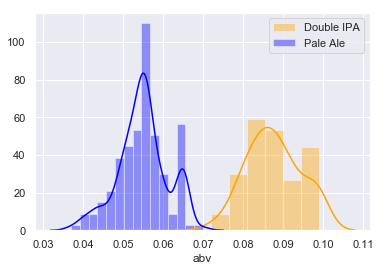

The strongest Double IPA has an ABV of: 9.9 %
The weakest Double IPA has an ABV of: 7.2 %
On average, Double IPAs have an ABV of: 8.8 %
---------------------------------------------
The strongest Pale Ale has an ABV of: 7.0 %
The weakest Pale Ale has an ABV of: 3.7 %
On average, Pale Ales have an ABV of: 5.5 %


In [6]:
# Let's examine the ABV distributions of Double IPAs and Pale Ales.
sns.distplot(ipa['abv'], label = 'Double IPA', color = 'orange')
sns.distplot(apa['abv'], label = 'Pale Ale', color = 'blue')
plt.legend()
plt.show()

# Display ABV summary statistics
print('The strongest Double IPA has an ABV of:', ipa_abv_max * 100,'%')
print('The weakest Double IPA has an ABV of:', round(ipa_abv_min * 100, 1), '%')
print('On average, Double IPAs have an ABV of:', round(ipa_abv_mean * 100, 1), '%')
print('---------------------------------------------')

print('The strongest Pale Ale has an ABV of:', round(apa_abv_max * 100, 1), '%')
print('The weakest Pale Ale has an ABV of:', round(apa_abv_min * 100, 1), '%')
print('On average, Pale Ales have an ABV of:', round(apa_abv_mean* 100, 1), '%')

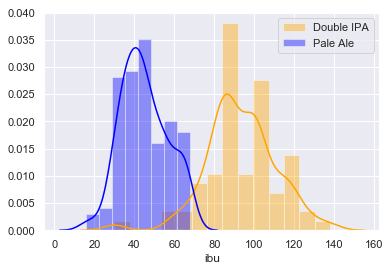

The most bitter Double IPA has an IBU of: 138.0
The least bitter Double IPA has an IBU of: 30.0
On average, Double IPAs have an IBU of: 93.0
---------------------------------------------
The most bitter Pale Ale has an IBU of: 68.0
The least bitter Pale Ale has an IBU of: 16.0
On average, Pale Ales have an IBU of: 45.0


In [7]:
# Now, let's examine the IBU distributions of each.
sns.distplot(ipa['ibu'], label = 'Double IPA', color = 'orange')
sns.distplot(apa['ibu'], label = 'Pale Ale', color = 'blue')
plt.legend()
plt.show()

# Display ABV summary statistics
print('The most bitter Double IPA has an IBU of:', ipa_ibu_max)
print('The least bitter Double IPA has an IBU of:', ipa_ibu_min)
print('On average, Double IPAs have an IBU of:', round(ipa_ibu_mean, 0))
print('---------------------------------------------')

print('The most bitter Pale Ale has an IBU of:',apa_ibu_max)
print('The least bitter Pale Ale has an IBU of:',apa_ibu_min)
print('On average, Pale Ales have an IBU of:',round(apa_ibu_mean, 0))

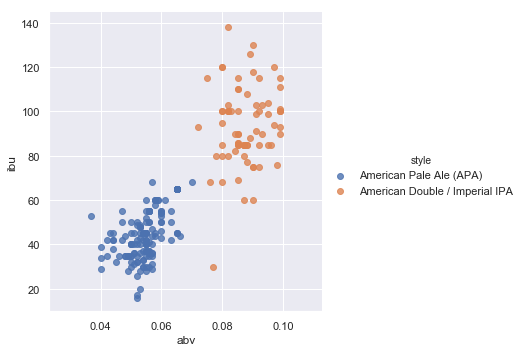

In [8]:
# Let's train a model to classify beers as either a Double IPA or Pale Ale.
# We're going to use Logistic Regression, as this is a classification problem.

# First, let's limit our df to only include IPAs and Pale Ales
df = df[(df['style'] == 'American Double / Imperial IPA') | (df['style'] == 'American Pale Ale (APA)')]

# Scatter plot
sns.lmplot(x = 'abv', y = 'ibu', hue = 'style', data = df, fit_reg = False)

Let's examine the Double IPA outlier and see if perhaps it was mislabeled.

In [9]:
ipa[ipa['ibu'] == 30]['name']

2398    Lights Out Vanilla Cream Extra Stout
Name: name, dtype: object

As shown above, this beer was mislabeled and should be considered a 'Stout'. Let's remove it from df, as it would likely be misclassified as a Pale Ale in our model.

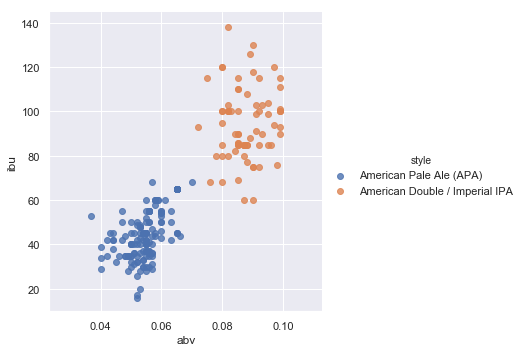

In [10]:
# Drop the mislabeled outlier
df = df.drop(df[df['name'] == 'Lights Out Vanilla Cream Extra Stout'].index)

# Confirm it has been removed
sns.lmplot(x = 'abv', y = 'ibu', hue = 'style', data = df, fit_reg = False)

The outlier has been removed. Let's now proceed to train the model.

In [11]:
# Create dummy variable for beer style
df = pd.concat([df, pd.get_dummies(df['style'], drop_first = True)], axis = 1)      

# Create feauture variable (ABV and IBU) and target variable (Style)
# Note Style is now a dummy variable instead of string
X = df[['abv','ibu']]
y = df[['American Pale Ale (APA)']]

# Create training and testing sets with test size of 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Instantiate LogisticRegression as logreg
logreg = LogisticRegression()

# Fit the model to the training data
logreg.fit(X_train, y_train.values.ravel())

# Predict the model on the test data
y_pred = logreg.predict_proba(X_test)

# Display the coefficients
print("Coefficients:", logreg.coef_)

# Compute the R^2
print("R^2:",format(round(logreg.score(X_test, y_test), 3)))

# Compute the log loss. We use log loss as the cost function for classification models.
# In short, log loss measures accuracy by penalizing false classifications. 
# Similar to MSE, a low log loss is correlated with a more accurate model.
logLoss = log_loss(y_test, y_pred)
print("Log Loss: {}".format(round(logLoss, 3)))

Coefficients: [[ 0.02177418 -0.07757396]]
R^2: 1.0
Log Loss: 0.183


C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
# Obtain the 5 fold cv scores for the model
logreg_scores = cross_val_score(logreg, X, y.values.ravel(), cv = 5, scoring = 'r2')
print('Cross-validated LogReg scores:', logreg_scores)

Cross-validated LogReg scores: [0.80215054 0.90107527 0.80215054 1.         1.        ]


C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

The R^2s and Log Loss displayed above indicate our model is quite accurate in classifying beers by style. However, knowing that stronger beers (ABV wise) are typically more bitter (in terms of IBU), we need to consider the collinearity between our two feature variables. If multicollinearity is apparent, we must train a new model as this violates a key assumption of logistic regression.


In [13]:
# Let's check the collinearity between ABV and IBU by computing the VIFs for each.
# We do this by regressing ABV on IBU (or vice versa), obtaining the R^2,
# and computing the VIF from this R^2.
# For an acceptable model, the VIF should be less than 5.

# Instantiate LinearRegression as linreg
linreg = LinearRegression()

# Compute VIF
abv = df[['abv']]
ibu = df[['ibu']]

def compute_vif(X, y):
    linreg.fit(X, y)
    r2 = linreg.score(X, y)
    print('R^2: ', round(r2, 3))
    vif = (1 / (1 - r2))
    print('VIF: ', round(vif, 3))
    
compute_vif(abv, ibu)

R^2:  0.763
VIF:  4.228


The VIF of 4.228 indicates the coefficients of our model are still likely biased. However, a VIF of less than 5 is acceptable when assessing multicollinearity. Thus, this model "passes" the multicollinearity test.